In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
# architecture variables
PATH = "data/dog_breeds/"

arch=resnet50
sz=224
bs=64
filename='resnet50v4'

In [5]:
pd.read_csv(label_csv).head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# get cross validation indexes of labels
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [5]:
# model variables
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz=sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, bs=bs, tfms=tfms, val_idxs=val_idxs,
                                       suffix='.jpg', test_name='test')
    return data #if sz>300 else data.resize(340, 'tmp')

In [6]:
# dataset
data = get_data(sz, bs)

In [7]:
# show random image from training set (for giggles)
# fname = random.choice(data.trn_ds.fnames)
# img = PIL.Image.open(PATH + fname)
# display(img); display(img.size)

In [8]:
# Train last layer
learn = ConvLearner.pretrained(arch, data)

# ps -> dropout parameters
# hyperparameter to control overfitting (train loss < val loss) by dropping random % of nodes in a layer

In [9]:
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 95%|█████████▍| 121/128 [00:51<00:02,  2.37it/s, loss=12.9]

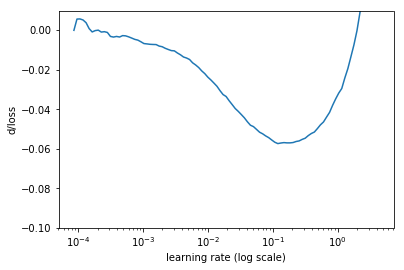

In [10]:
learn.lr_find()
# learn.sched.plot_lr()
# learn.sched.plot()
plot_loss_change(learn.sched, sma=20, y_lim=(-0.1, 0.01))

In [11]:
lr = 1e-1
lrs = np.array([1e-5, 1e-4, lr])

In [12]:
# SGDR (one restart per epoch)
learn.fit(lr, 5, cycle_len=1)

# start doing our usual minibatch gradient descent with a given learning rate (lr)
# while gradually decreasing it (fast.ai uses “cosine annealing”) until the end of the cycle

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

 10%|█         | 13/128 [00:06<00:54,  2.13it/s, loss=4.44]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[0.      1.00023 0.51006 0.84788]                           
[1.      0.70548 0.49717 0.8484 ]                            
[2.      0.59059 0.46479 0.86309]                            
[3.      0.51607 0.47479 0.85081]                            
 41%|████▏     | 53/128 [00:22<00:32,  2.34it/s, loss=0.474]


KeyboardInterrupt: 

In [13]:
learn.save('224v4_last')

In [20]:
learn.load('224v4_last')

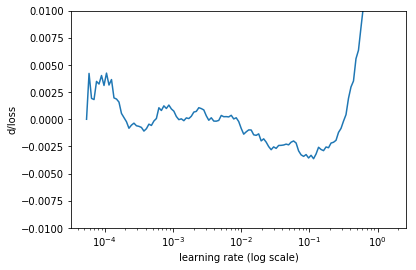

In [22]:
learn.set_data(get_data(400, 50))
learn.lr_find()
plot_loss_change(learn.sched, sma=20, y_lim=(-0.01, 0.01))

In [23]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.58363 0.45746 0.85925]                            
[1.      0.50147 0.46129 0.86845]                            
[2.      0.46087 0.45448 0.86754]                            



In [24]:
learn.save('400v4_last')

In [26]:
learn.unfreeze()
learn.bn_freeze(True)
lr = 1e-2
learn.fit(lrs, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 0/164 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512387374934/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
learn.load('224v3')

In [ ]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [14]:
# Test Time Augmentation

log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [15]:
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [16]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(SUBM+filename, index=False)

In [17]:
# submit to kaggle via cli
! kg submit {SUBM+filename} -c dog-breed-identification

0.47167
